# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


# <hr\>
**Общая информация**

**Срок сдачи:** до 7 октября 2017, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 7 октября, -4 балла после 06:00 14 октября, -6 баллов после 06:00 21 октября

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [ ]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()

## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [ ]:
# Здесь все нормально
df_titanic.Survived.value_counts()

In [ ]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

In [ ]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [ ]:
df_titanic.Embarked.head()

In [ ]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

In [ ]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [ ]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [ ]:
bow

In [ ]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print u'столбец %d: %s' % (i, w)

# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [ ]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [ ]:
df_wine.head()

Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [ ]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [ ]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

In [ ]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучаеть классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [ ]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

Далее вы увидете пример реализации этого простого классификатора.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [ ]:
model = SimpleClassifier()
model.fit(X, y)

print 'Оптимальный порог: %f' % model.threshold

Получаем предсказание модели (на обучающей выборке)

In [ ]:
y_hat = model.predict(X)

Оценим долю ошибок на обучающей выборке

In [ ]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print 'Доля ошибок на обучающей выборке: %f' % error_rate

## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [ ]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

In [ ]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [ ]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print 'Доля ошибок на контрольной выборке: %f' % error_rate

Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [291]:
from sklearn.base import BaseEstimator, ClassifierMixin, ClusterMixin
from sklearn.metrics.pairwise import distance_metrics

class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        ## Случайное заполнение массива с центройдами кластеров
        self.centroids = np.random.randn(self.k, X.shape[1])
        
        i = 0
        dr = 1
        ## Необходимое отклонение
        Eps = 0.00001
        
        while(i < self.max_iter and dr > Eps):
            #Заполнение массива меток
            self.labels = distance_metrics()[self.metric](X, self.centroids).argmin(axis=1)
            #Пересчёт центроидов
            old_centroids = np.array(self.centroids)
            for k in range(self.k):
                l = np.count_nonzero(self.labels == k)
                if l != 0:
                    self.centroids[k] = sum([X[j] for j in range(X.shape[0]) if self.labels[j] == k]) / l
            
            # Суммарное отклонение центроидов от прошлого положения
            dr = sum(np.sum(distance_metrics()[self.metric](old_centroids, self.centroids), axis=1))
            i += 1
        return self
        
    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        result = []
        ##С помощью distance_metrics() вычисляем расстояние, с помощью argmin ищем метку ближайшего, выдаём 
        for j in range(X.shape[0]):
            result.append(distance_metrics()[self.metric](X, self.centroids).argmin(axis=1))
        return result
            



In [319]:
class MiniBatchKmeans(Kmeans):
    def __init__(self, batch_size, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        #Обращаемся к инициализатору родительского класса
        Kmeans.__init__(self, k, metric, max_iter, random_state, init)
        self.batch_size = batch_size
    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        self.centroids = np.random.randn(self.k, X.shape[1])
        # Размер minibatch
        b = self.batch_size
        i = 0
        dr = 1
        # Необходимое отклонение
        Eps = 0.00001
        while(i < self.max_iter and dr > Eps):
            # Случайная выборка b точек
            X_batch = X[np.random.permutation(X.shape[0])[:b]]
            # Заполнение массива меток
            self.labels = distance_metrics()[self.metric](X_batch, self.centroids).argmin(axis=1)
            # Пересчёт центроидов
            old_centroids = np.array(self.centroids)
            for k in range(self.k):
                l = np.count_nonzero(self.labels == k)
                if l != 0:
                    self.centroids[k] = sum([X_batch[j] for j in range(X_batch.shape[0]) if self.labels[j] == k]) / l

            # Суммарное отклонение центроидов от прошлого положения
            dr = sum(np.sum(distance_metrics()[self.metric](old_centroids, self.centroids), axis=1))
            i += 1
        # Вычисляем весь массив меток
        self.labels = distance_metrics()[self.metric](X, self.centroids).argmin(axis=1)
        return self

In [355]:
from sklearn.base import BaseEstimator, ClassifierMixin, ClusterMixin
from sklearn.metrics.pairwise import distance_metrics
import random

class Kmeanspp(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        cur_cent = np.empty((self.k, X.shape[1]))
        # Берём случайную точку, устанавливаем её центроидом
        cur_cent[0] = np.random.rand(1, X.shape[1])
        j = 1;
        # Цикл для заполнения массива центроидов
        while j < self.k:
            # Поиск наименьшего
            ds = distance_metrics()[self.metric](X, cur_cent).argmin(axis=1)
            # Сумма расстояний до прежде вычисленных центроидов
            sm = sum(distance_metrics()[self.metric](X[ty].reshape(1,X.shape[1]), cur_cent[ds[ty]].reshape(1,X.shape[1])) for ty in range(X.shape[0]))
            # Берём число из интервал от 0 до суммы
            rnd = random.random() * sm;
            t = 0
            q = 0
            # Цикл для вычисления точки - нового центроида. Условие прерывания - когда сумма расстояний превысит rnd
            while (t < rnd):
                # Поиск минимальных расстояний
                tdl = distance_metrics()[self.metric](X[q].reshape(1,X.shape[1]), cur_cent)
                dt = tdl.argmin(axis=1)
                q += 1
                t += distance_metrics()[self.metric](X[q].reshape(1,X.shape[1]), cur_cent[dt[0]].reshape(1,X.shape[1]))
            # Добавляем точку в массив центроидов
            cur_cent[j] = X[q]
            j += 1
        self.centroids = cur_cent
        # После этого идёт стандартный Kmean
        i = 0
        dr = 1
        Eps = 0.00001
        while(i < self.max_iter and dr > Eps):
            #присвоить категории
            self.labels = distance_metrics()[self.metric](X, self.centroids).argmin(axis=1)
            # пересчитать центроиды, взяв среднее
            old_centroids = np.array(self.centroids)
            for k in range(self.k):
                l = np.count_nonzero(self.labels == k)
                if l != 0:
                    self.centroids[k] = sum([X[j] for j in range(X.shape[0]) if self.labels[j] == k]) / l
            
            # суммарное отклонение центроидов от прошлого положения
            dr = sum(np.sum(distance_metrics()[self.metric](old_centroids, self.centroids), axis=1))
            i += 1
        return self
        
    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        result = []
        for j in range(X.shape[0]):
            result.append(distance_metrics()[self.metric](X, self.centroids).argmin(axis=1))
        return result

In [358]:
class MiniBatchKmeanspp(Kmeanspp):
    def __init__(self, batch_size, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        # Обращаемся к инициализатору родительского класса
        Kmeanspp.__init__(self, k, metric, max_iter, random_state, init)
        self.batch_size = batch_size
    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))
        # Код следующей части схож с кодом Kmean++, но есть различия, которые и будут прокомментированы
        cur_cent = np.empty((self.k, X.shape[1]))
        cur_cent[0] = np.random.rand(1, X.shape[1])
        j = 1;
        while j < self.k:
            ds = distance_metrics()[self.metric](X, cur_cent).argmin(axis=1)
            sm = sum(distance_metrics()[self.metric](X[ty].reshape(1,X.shape[1]), cur_cent[ds[ty]].reshape(1,X.shape[1])) for ty in range(X.shape[0]))
            rnd = random.random() * sm;
            t = 0
            q = 0
            while (t < rnd):
                tdl = distance_metrics()[self.metric](X[q].reshape(1,X.shape[1]), cur_cent)
                dt = tdl.argmin(axis=1)
                q += 1
                t += distance_metrics()[self.metric](X[q].reshape(1,X.shape[1]), cur_cent[dt[0]].reshape(1,X.shape[1]))
            cur_cent[j] = X[q]
            j += 1
        self.centroids = cur_cent
        i = 0
        dr = 1
        Eps = 0.00001
        # Заносим в b размер batch
        b = self.batch_size
        while(i < self.max_iter and dr > Eps):
            # Работаем с массивом minibatch из b точек, случайно взятых из X
            X_batch = X[np.random.permutation(X.shape[0])[:b]]
            #присвоить категории
            self.labels = distance_metrics()[self.metric](X_batch, self.centroids).argmin(axis=1)
            # пересчитать центроиды, взяв среднее
            old_centroids = np.array(self.centroids)
            for k in range(self.k):
                l = np.count_nonzero(self.labels == k)
                if l != 0:
                    self.centroids[k] = sum([X_batch[j] for j in range(X_batch.shape[0]) if self.labels[j] == k]) / l
            
            # суммарное отклонение центроидов от прошлого положения
            dr = sum(np.sum(distance_metrics()[self.metric](old_centroids, self.centroids), axis=1))
            i += 1
        # Вычисляем весь массив меток
        self.labels = distance_metrics()[self.metric](X, self.centroids).argmin(axis=1)
        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [47]:
from sklearn.datasets import make_blobs

In [48]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

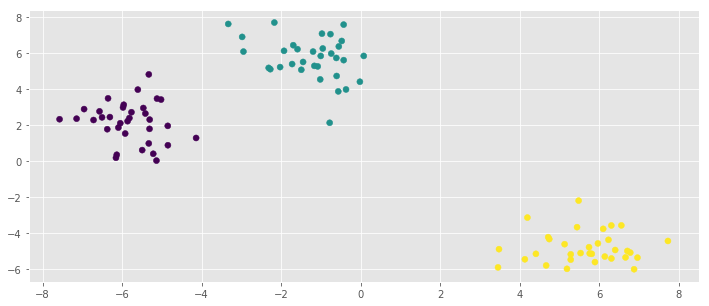

In [49]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта задание не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

0.574570894241


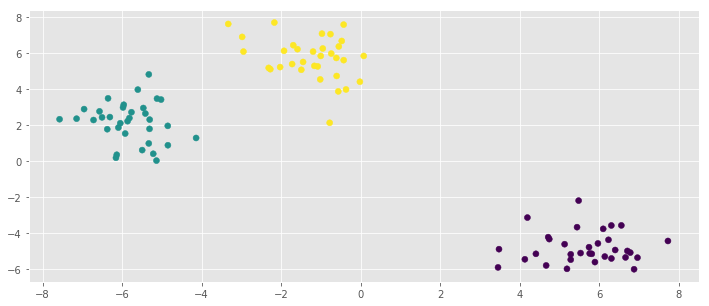

In [260]:
## Работоспособность KMeans
K = Kmeans(k=3)
K = K.fit(X)
plt.scatter(X[:,0], X[:, 1], c = K.labels)

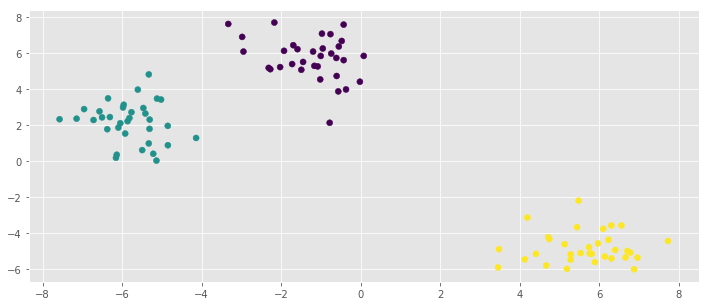

In [242]:
## Работоспособность KMeans++
K = Kmeanspp(k=3)
K = K.fit(X)
plt.scatter(X[:,0], X[:, 1], c = K.labels)

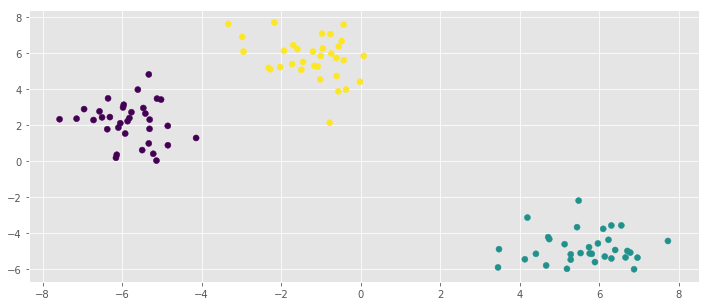

In [320]:
## Работоспособность KMeans с MiniBatchKMeans
K = MiniBatchKmeans(batch_size = 3, k=3)
K = K.fit(X)
plt.scatter(X[:,0], X[:, 1], c = K.labels)

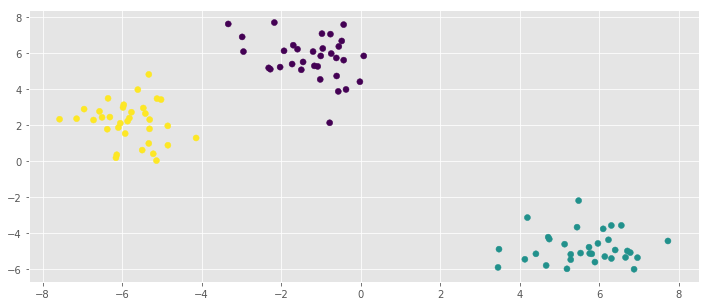

In [321]:
## Работоспособность KMeans++ с MiniBatchKMeans
K = MiniBatchKmeanspp(batch_size = 3, k=3)
K = K.fit(X)
plt.scatter(X[:,0], X[:, 1], c = K.labels)

In [296]:
## Время выполнения алгоритма KMeans
K = Kmeans(k=3)
%timeit -n 1 K.fit(X)

1 loop, best of 3: 506 ms per loop


In [297]:
## Время выполнения алгоритма KMeans++
K = Kmeanspp(k=3)
%timeit -n 1 K.fit(X)

1 loop, best of 3: 557 ms per loop


In [322]:
## Время выполнения алгоритма KMeans с MiniBatchKMeans
K = MiniBatchKmeans(batch_size = 3, k=3)
%timeit -n 1 K.fit(X)

1 loop, best of 3: 229 ms per loop


In [323]:
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans
K = MiniBatchKmeanspp(batch_size = 3, k=3)
%timeit -n 1 K.fit(X)

1 loop, best of 3: 320 ms per loop


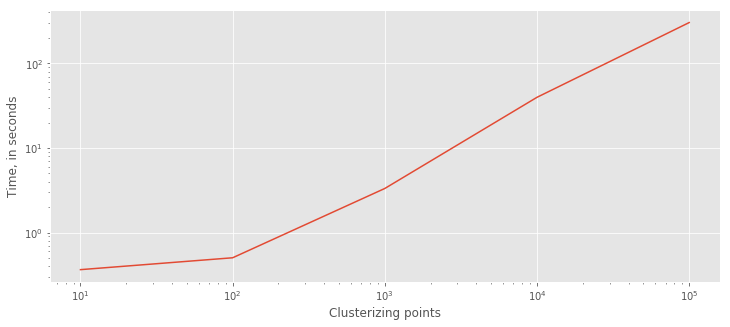

In [413]:
import time
Count = 5
xk = np.logspace(1, Count, num = Count).astype(int)
a_kmeans = np.empty([0])
for i in range(0, Count):
    X1, y = make_blobs(n_samples=xk[i], n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    K = Kmeans(k=3)
    tr1 = time.time()
    K.fit(X1)
    tr2 = time.time()
    a_kmeans = np.append(a_kmeans, tr2 - tr1)
plt.plot(xk, a_kmeans)
plt.xlabel("Clusterizing points")
plt.ylabel("Time, in seconds")
plt.xscale("log")
plt.yscale("log")

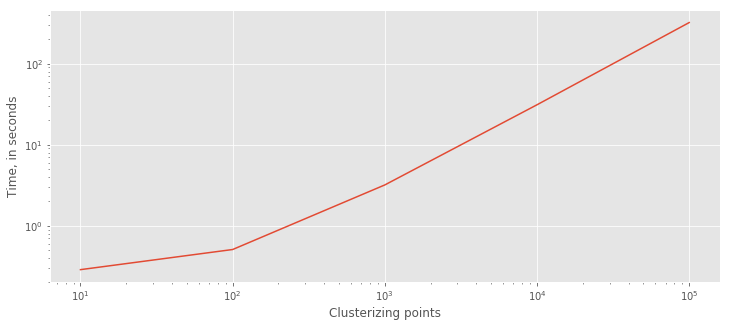

In [414]:
xk = np.logspace(1, Count, num = Count).astype(int)
a_kmeans = np.empty([0])
for i in range(0, Count):
    X1, y = make_blobs(n_samples=xk[i], n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    K = Kmeanspp(k=3)
    tr1 = time.time()
    K.fit(X1)
    tr2 = time.time()
    a_kmeans = np.append(a_kmeans, tr2 - tr1)
plt.plot(xk, a_kmeans)
plt.xlabel("Clusterizing points")
plt.ylabel("Time, in seconds")
plt.xscale("log")
plt.yscale("log")

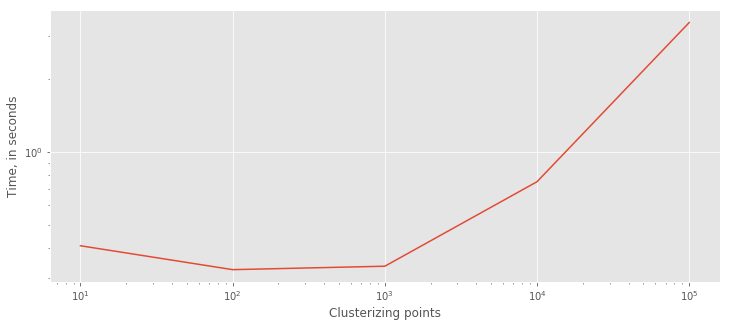

In [415]:
xk = np.logspace(1, Count, num = Count).astype(int)
a_kmeans = np.empty([0])
for i in range(0, Count):
    X1, y = make_blobs(n_samples=xk[i], n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    K = MiniBatchKmeans(batch_size = 5, k=3)
    tr1 = time.time()
    K.fit(X1)
    tr2 = time.time()
    a_kmeans = np.append(a_kmeans, tr2 - tr1)
plt.plot(xk, a_kmeans)
plt.xlabel("Clusterizing points")
plt.ylabel("Time, in seconds")
plt.xscale("log")
plt.yscale("log")

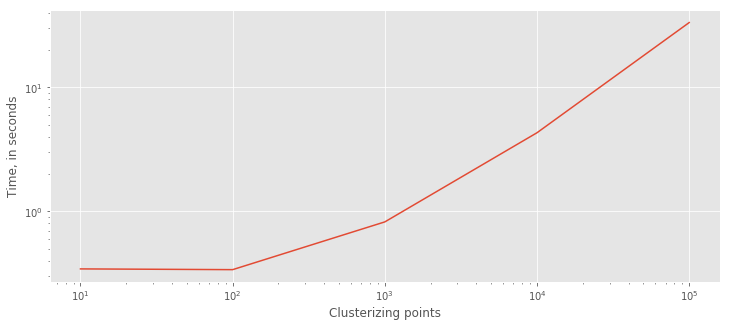

In [416]:
xk = np.logspace(1, Count, num = Count).astype(int)
a_kmeans = np.empty([0])
for i in range(0, Count):
    X1, y = make_blobs(n_samples=xk[i], n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    K = MiniBatchKmeanspp(batch_size = 5, k=3)
    tr1 = time.time()
    K.fit(X1)
    tr2 = time.time()
    a_kmeans = np.append(a_kmeans, tr2 - tr1)
plt.plot(xk, a_kmeans)
plt.xlabel("Clusterizing points")
plt.ylabel("Time, in seconds")
plt.xscale("log")
plt.yscale("log")

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [325]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns = df_sns.drop(['gradyear', 'gender', 'age', 'friends'], axis = 1)
df_sns.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


In [331]:
df_sns -= df_sns.mean()
df_sns /= df_sns.std()
df_sns.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
1,-0.332212,1.060031,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,1.067374,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
2,-0.332212,1.060031,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,2.027874,-0.220399,-0.174905
3,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
4,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,2.273635,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,2.285084,2.719271


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [352]:
## KMeans
sns_kmean = Kmeans(k=9, max_iter = 40)
clust_val = sns_kmean.fit(df_sns.values)

In [361]:
df_sns['class'] = clust_val.labels
for i in range(0, 9):
    print i, (sns_kmean.labels == i).sum()
Fk = pd.DataFrame(columns = df_sns.columns, data = sns_kmean.centroids).transpose()
for i in range(0, 9):
    print(Fk. loc[:, i]).sort_values()[-5: ]

0 4115
1 483
2 19651
3 336
4 2230
5 937
6 1186
7 588
8 474
cute            0.625189
cheerleading    0.666770
abercrombie     0.677564
hollister       0.725649
shopping        0.897190
Name: 0, dtype: float64
bible       0.158796
clothes     0.172041
shopping    0.444440
class       1.066253
swimming    5.262522
Name: 1, dtype: float64
god      -0.066738
blonde   -0.029924
jesus    -0.024689
bible     0.000691
class     3.980866
Name: 2, dtype: float64
hair     0.319906
sex      0.369914
cute     0.788208
class    1.169643
sexy     6.054579
Name: 3, dtype: float64
softball      1.289763
basketball    1.375229
baseball      1.397568
football      1.530486
class         7.815695
Name: 4, dtype: float64
sex       2.128568
hair      2.622561
drugs     2.901508
kissed    3.221169
class     5.910352
Name: 5, dtype: float64
mall        0.445683
cute        0.579051
shopping    0.594024
dance       1.849238
dress       2.899253
Name: 6, dtype: float64
rock        0.200481
music       0.510807
b

In [356]:
## KMeans++
sns_kmean = Kmeanspp(k=9, max_iter = 40)
clust_val = sns_kmean.fit(df_sns.values)

In [357]:
df_sns['class'] = clust_val.labels
for i in range(0, 9):
    print i, (sns_kmean.labels == i).sum()
Fk = pd.DataFrame(columns = df_sns.columns, data = sns_kmean.centroids).transpose()
for i in range(0, 9):
    print(Fk. loc[:, i]).sort_values()[-5: ]

0 4115
1 483
2 19651
3 336
4 2230
5 937
6 1186
7 588
8 474
cute            0.625189
cheerleading    0.666770
abercrombie     0.677564
hollister       0.725649
shopping        0.897190
Name: 0, dtype: float64
bible       0.158796
clothes     0.172041
shopping    0.444440
class       1.066253
swimming    5.262522
Name: 1, dtype: float64
god      -0.066738
blonde   -0.029924
jesus    -0.024689
bible     0.000691
class     3.980866
Name: 2, dtype: float64
hair     0.319906
sex      0.369914
cute     0.788208
class    1.169643
sexy     6.054579
Name: 3, dtype: float64
softball      1.289763
basketball    1.375229
baseball      1.397568
football      1.530486
class         7.815695
Name: 4, dtype: float64
sex       2.128568
hair      2.622561
drugs     2.901508
kissed    3.221169
class     5.910352
Name: 5, dtype: float64
mall        0.445683
cute        0.579051
shopping    0.594024
dance       1.849238
dress       2.899253
Name: 6, dtype: float64
rock        0.200481
music       0.510807
b

In [370]:
## KMeans с MiniBatchKMeans
sns_kmean = MiniBatchKmeans(batch_size = 5000, k=9, max_iter = 40)
clust_val = sns_kmean.fit(df_sns.values)

In [371]:
df_sns['class'] = clust_val.labels
for i in range(0, 9):
    print i, (sns_kmean.labels == i).sum()
Fk = pd.DataFrame(columns = df_sns.columns, data = sns_kmean.centroids).transpose()
for i in range(0, 9):
    print(Fk. loc[:, i]).sort_values()[-5: ]

0 382
1 327
2 3176
3 548
4 20353
5 444
6 2047
7 699
8 2024
rock          0.725028
basketball    1.318232
football      1.325854
class         2.375000
baseball      6.597220
Name: 0, dtype: float64
death       0.310824
music       0.581965
class       2.000000
band        4.588665
marching    6.708914
Name: 1, dtype: float64
drunk          0.474518
hollister      0.750685
abercrombie    0.788865
sexy           1.322246
class          1.786792
Name: 2, dtype: float64
mall       0.379978
cute       0.383291
clothes    0.398732
class      5.282609
hot        5.293685
Name: 3, dtype: float64
jesus      -0.060647
softball   -0.036061
blonde     -0.027095
tennis     -0.007360
class       7.030774
Name: 4, dtype: float64
clothes     0.163563
cute        0.220743
shopping    0.225195
swimming    4.981289
class       6.225806
Name: 5, dtype: float64
cute        1.102990
shopping    1.133797
dress       1.175199
clothes     1.225730
class       5.070336
Name: 6, dtype: float64
sex       2.202361

In [372]:
## KMeans++ с MiniBatchKMeans
sns_kmean = MiniBatchKmeanspp(batch_size = 5000, k=9, max_iter = 40)
clust_val = sns_kmean.fit(df_sns.values)

In [373]:
df_sns['class'] = clust_val.labels
for i in range(0, 9):
    print i, (sns_kmean.labels =7= i).sum()
Fk = pd.DataFrame(columns = df_sns.columns, data = sns_kmean.centroids).transpose()
for i in range(0, 9):
    print(Fk. loc[:, i]).sort_values()[-5: ]

0 698
1 3915
2 786
3 2902
4 19919
5 802
6 226
7 272
8 480
rock        0.579814
football    0.783695
band        2.118271
marching    3.489395
baseball    3.778492
Name: 0, dtype: float64
sports      0.736974
dress       0.739373
soccer      0.794594
football    0.800509
class       6.968230
Name: 1, dtype: float64
hair           0.453632
shopping       0.772647
class          2.619048
hollister      4.032498
abercrombie    4.444500
Name: 2, dtype: float64
cute     0.228630
drunk    0.392757
hot      0.871769
sexy     1.733710
class    2.189873
Name: 3, dtype: float64
swimming   -0.061475
bible      -0.060130
jesus      -0.055559
blonde     -0.027695
class       4.016250
Name: 4, dtype: float64
sex       2.220112
drugs     2.772867
hair      2.895636
kissed    3.378649
class     6.953704
Name: 5, dtype: float64
church    1.574058
class     2.073171
god       3.938874
jesus     4.335636
bible     8.238574
Name: 6, dtype: float64
shopping    0.247460
sports      0.250696
soccer      0.267

## Вывод
Есть явно выделяющиеся кластеры:

Спортсмены(интересы связаны со спортом), часто спортсменов несколько кластеров

Любящие проводить время за покупками и уходом за собой.

Религиозные(интересы - Бог, Иисус, Библия)

Люди, предпочитающие вести "свободный образ жизни"(интересы - "sex", "drugs", "hot")

"Стандартные люди", не имеющие определённых интересов. Приоритетный интерес - класс

# Сравнение методов

Из вышележащих графиков очевидно существенное превосходство 
в скорости работы методов с MiniBatch